goal
- [done] SVGP + dirichlet training on mnist
    - recreate evidential DL example ... 
- [done] variational learning of supporting image patches !
    - [done] impl STN ... 
    - observations
        - perf okay if allows finetune encoder network 
        - not so much as evidence that is localized ... 
            - perhaps due to fact shared inducing locations ... \
                would want to retain all info (not localized) and \
                use variational mean to modulate evidence for class
            - so to get localized info ... might want to do per-class inducing variables
            - also might want to put STN to kernel hyperparam ...\
                and put product kernel over both image and affine trans matrix 
            - might also try just using one STN for entire thing 

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

from collections import defaultdict

import scipy
import numpy as onp
onp.set_printoptions(precision=3,suppress=True)

import jax
import jax.numpy as np
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from jax import grad, jit, vmap, device_put, random
from flax import linen as nn
from jax.scipy.stats import dirichlet
import optax

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.patches as mpl_patches

# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.linewidth'] = 3
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate
from functools import partial
import copy

from setup_convgp import *
from plt_utils import *
from gpax import *
from dataset import *

jax_status()

jax/jaxlib:	 0.2.14 (0, 1, 66)
platform:	 gpu
gpu counts:	 1
devices:	 [GpuDevice(id=0, process_index=0)]


In [2]:
key = random.PRNGKey(1)
# Y_subset = [0,1]
Y_subset = [0,1,2,3,4,5,6,7,8,9]
dataset_name = 'cifar10'
X_train, y_train, X_test, y_test = load_mnist() # load_cifar10() # load_mnist() 
X_train, y_train = XY_subset(X_train, y_train, Y_subset)
X_test, y_test = XY_subset(X_test, y_test, Y_subset)

X_train = jax_to_gpu(np.asarray(X_train))
y_train = jax_to_gpu(np.asarray(y_train))
X_test = jax_to_gpu(np.asarray(X_test))
y_test = jax_to_gpu(np.asarray(y_test))

data_train = (X_train, y_train)
data_test = (X_test, y_test)

print(X_train.shape, y_train.shape)
print(np.min(X_train), np.max(X_train))


(60000, 28, 28, 1) (60000, 1)
0.0 1.0


Text(0.5, 1.0, '[0]')

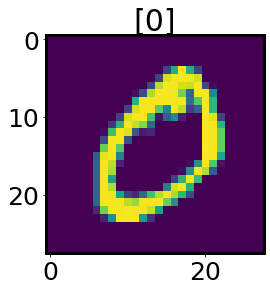

In [3]:
n = 1
plt.imshow(X_train[n])
plt.title(y_train[n])

In [ ]:
print(np.where(y_test==0)[0][:10])

ind = 1
n_ims = 20

fig, axs = plt.subplots(1,n_ims,figsize=(2*n_ims,2))
[axi.set_xticks([]) for axi in axs.ravel()]; [axi.set_yticks([]) for axi in axs.ravel()]

x, y = X_test[ind], y_test[ind]

x_rot = rotated_ims(x, n_ims=n_ims)
for i in range(n_ims):
    ax = axs[i]
    ax.imshow(x_rot[i], cmap='Greys')



In [121]:
import ml_collections 

def get_config_mnist_supervised():
    
    config = ml_collections.ConfigDict()
    
    config.image_shape = (28, 28, 1)
    
    # optimization 
    config.learning_rate = .03
    config.batch_size = 64
    config.n_epochs = 30
    
    
    return config


config = get_config_mnist_supervised()
config
    



batch_size: 64
image_shape: !!python/tuple
- 28
- 28
- 1
learning_rate: 0.03
n_epochs: 30

In [203]:

from flax.training import train_state
import functools

class TrainState(train_state.TrainState):
    """ Keeps track of parameters, optimizer state, rng, 
            mutable states in training 
    """
    # `TrainState` attributes: 
    # step: int
    # apply_fn: Callable = struct.field(pytree_node=False)
    # params: core.FrozenDict[str, Any]
    # tx: optax.GradientTransformation = struct.field(pytree_node=False)
    # opt_state: optax.OptState
    #
    batch_stats: Any
    rng: Any
        
    # jitted model's apply_fn for evaluation, use
    #     `struct.field(pytree_node=False)` to avoid type checks
    apply_fn_eval_jitted: Callable = struct.field(pytree_node=False,
                                                  default=None)
        
    @property
    def variables(self):
        return freeze({'params': self.params,
                       'batch_stats': self.batch_stats})

    @property
    def apply_fn_eval(self):
        """ Note separate calls to this function 
                redo the jitting ... so is expensive
            If state unchanged, then better write 
                ```
                apply_fn_eval = state.get_apply_fn_eval()
                [apply_fn_eval(X) for X in dataset]
                ```
        """
        if self.apply_fn_eval_jitted is None:
            import inspect
            apply_fn = self.apply_fn
            sig = inspect.signature(self.apply_fn)
            kwargs = {'train': False} \
                if 'train' in sig.parameters else {}
            apply_fn = partial(apply_fn, **kwargs)
            apply_fn = jax.jit(apply_fn)
            # Use `object.__setattr__` to mutate 
            #     fields in @dataclass(frozen=True)
            object.__setattr__(
                self, 'apply_fn_eval_jitted', apply_fn)
        return self.apply_fn_eval_jitted

        
@jax.jit
def compute_metrics(logits, labels):
    label_onehot = jax.nn.one_hot(labels.squeeze(), 10)
    loss = np.mean(optax.softmax_cross_entropy(logits=logits,
                                               labels=label_onehot))
    pred = np.argmax(logits, -1).reshape(labels.shape)
    accuracy = np.mean(pred == labels)
    metrics = {'loss': loss, 'accuracy': accuracy}
    return metrics


@jax.jit
def train_step(state, batch):
    state_rng, train_rng = random.split(state.rng)
    X, y = batch
    def loss_fn(params):
        y_onehot = jax.nn.one_hot(y, 10).squeeze()
        logits, mutable_state = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            X, mutable=['batch_stats'])
        # mutable_state: {'batch_stats': {...}}
        loss = np.mean(optax.softmax_cross_entropy(logits=logits,
                                                   labels=y_onehot))
        aux = (logits, mutable_state)
        return loss, aux
    grad_fn = jax.value_and_grad(loss_fn,
                                 has_aux=True)
    (loss, aux), grads = grad_fn(state.params)
    logits, mutable_state = aux
    # `state.apply_gradients(grads)` does 3 things 
    #     - compute updates given gradient transformation `state.tx` & `grads`
    #     - apply the updates using `optax.apply_updates`
    #     - update `step`, `params`, `opt_state`, etc. attached to `state`
    state = state.apply_gradients(
        grads=grads,
        batch_stats=mutable_state['batch_stats'],
        rng=state_rng)
    metrics = compute_metrics(logits, y)
    log = {'loss': loss,
           'accuracy': metrics['accuracy']}
    return state, log



def eval_model(state, data_test):
    test_n_batches, test_batches = get_data_stream(
        random.PRNGKey(0), 100, data_test)

    logits = []
    labels = []
    for _ in range(test_n_batches):
        batch = next(test_batches)
        X, y = batch
        logit = state.apply_fn_eval(state.variables,
                                    X)
        labels.append(y.reshape(-1, 1))
        logits.append(logit)

    logits = np.vstack(logits)
    labels = np.vstack(labels)
    metrics = compute_metrics(logits, labels)
    metrics = jax.tree_map(lambda x: x.item(),
                           metrics)
    return metrics

        


key = random.PRNGKey(0)




model = CNNMnist(output_dim=10)

x_init = np.ones((1, config.image_shape[0], config.image_shape[1], 1))
variables = model.init(key, x_init)

tx = optax.sgd(config.learning_rate,
               nesterov=True)

key, state_key = random.split(key)
state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
    batch_stats=variables['batch_stats'] if \
        'batch_stats' in variables else {},
    rng=state_key)

train_n_batches, train_batches = get_data_stream(
    key, config.batch_size, data_train)

for epoch in range(config.n_epochs):
    logs = defaultdict(list)
    for it in range(train_n_batches):
        step = epoch*train_n_batches+it
        batch = next(train_batches)
        state, log = train_step(state, batch)
        variables = state.variables
        
        for k, v in log.items():
            logs[k].append(v)
        if step%(train_n_batches//10)==0:
            avg_metrics = {k: np.mean(np.array(v))
                           for k, v in logs.items()}
            print(f'[{epoch:3}|{100*it/train_n_batches:5.2f}%]\t'
                  f'Loss={avg_metrics["loss"]:.3f}\t'
                  f'accuracy={avg_metrics["accuracy"]:.3f}\t')
            
    
    metrics = eval_model(state, data_test)
    print(f'[{epoch:3}] test \t'
          f'Loss={metrics["loss"]:.3f}\t'
          f'accuracy={metrics["accuracy"]:.3f}\t')
    

[  0| 0.00%]	Loss=2.289	accuracy=0.156	
[  0| 9.91%]	Loss=1.345	accuracy=0.619	
[  0|19.83%]	Loss=0.947	accuracy=0.723	
[  0|29.74%]	Loss=0.768	accuracy=0.773	
[  0|39.66%]	Loss=0.673	accuracy=0.800	
[  0|49.57%]	Loss=0.603	accuracy=0.820	
[  0|59.49%]	Loss=0.554	accuracy=0.835	
[  0|69.40%]	Loss=0.514	accuracy=0.847	
[  0|79.32%]	Loss=0.484	accuracy=0.855	
[  0|89.23%]	Loss=0.458	accuracy=0.863	
[  0|99.15%]	Loss=0.436	accuracy=0.869	
[  0] test 	Loss=0.218	accuracy=0.933	
[  1| 9.06%]	Loss=0.220	accuracy=0.931	
[  1|18.98%]	Loss=0.210	accuracy=0.935	
[  1|28.89%]	Loss=0.208	accuracy=0.937	
[  1|38.81%]	Loss=0.202	accuracy=0.939	
[  1|48.72%]	Loss=0.197	accuracy=0.940	
[  1|58.64%]	Loss=0.192	accuracy=0.942	
[  1|68.55%]	Loss=0.190	accuracy=0.943	
[  1|78.46%]	Loss=0.186	accuracy=0.944	
[  1|88.38%]	Loss=0.183	accuracy=0.945	
[  1|98.29%]	Loss=0.180	accuracy=0.946	
[  1] test 	Loss=0.236	accuracy=0.922	
[  2| 8.21%]	Loss=0.154	accuracy=0.956	
[  2|18.12%]	Loss=0.155	accuracy=0.955	
[ 

KeyboardInterrupt: 

In [ ]:

output_dim = len(Y_subset)

    
def model_def():
    # return CNNMnist(output_dim=output_dim)
    return CNNMnist(output_dim=output_dim)


def compute_metrics(logits, labels):
    loss = np.mean(optax.softmax_cross_entropy(
        logits=logits, labels=jax.nn.one_hot(labels.squeeze(), output_dim)))
    pred = np.argmax(logits, -1).reshape(labels.shape)
    accuracy = np.mean(pred == labels)
    metrics = {'loss': loss, 'accuracy': accuracy}
    return metrics


@jax.jit
def logit_fn(params, X):
    logits = model_def().apply(params, X)
    return logits


@jax.jit
def train_step(opt, batch, key):
    key, subkey = random.split(key)
    X, y = batch
    y_onehot = jax.nn.one_hot(y, output_dim).squeeze()
    def loss_fn(params):
        logits = model_def().apply(params, X)
        loss = np.mean(optax.softmax_cross_entropy(
            logits=logits, labels=y_onehot))
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grad = grad_fn(opt.target)
    opt = opt.apply_gradient(grad)
    metrics = compute_metrics(logits, y)
    log = {'loss': loss,
           'accuracy': metrics['accuracy']}
    return opt, log, key


def eval_model(params, data_test, logit_fn=logit_fn):
    test_n_batches, test_batches = get_data_stream(
        random.PRNGKey(0), 100, data_test)

    logits = []; labels = []
    for _ in range(test_n_batches):
        batch = next(test_batches)
        X, y = batch
        logit = logit_fn(params, X)
        labels.append(y.reshape(-1, 1))
        logits.append(logit)

    logits = np.vstack(logits)
    labels = np.vstack(labels)
    metrics = compute_metrics(logits, labels)
    metrics = jax.tree_map(lambda x: x.item(), metrics)
    return metrics


In [ ]:
model = model_def()
params = model.init(key, X_train[:1])
opt = flax_create_optimizer(params, 'Adam', {'learning_rate': .03})

In [ ]:
bsz = 64
train_n_batches, train_batches = get_data_stream(key, bsz, data_train)
n_epochs = 30


for epoch in range(n_epochs):
    logs = defaultdict(list)
    for it in range(train_n_batches):
        step = epoch*train_n_batches+it
        batch = next(train_batches)
        opt, log, key = train_step(opt, batch, key)
        params = opt.target
        for k, v in log.items():
            logs[k].append(v)
        if step%(train_n_batches//10)==0:
            avg_metrics = {k: np.mean(np.array(v))
                           for k, v in logs.items()}
            print(f'[{epoch:3}|{100*it/train_n_batches:5.2f}%]\t'
                  f'Loss={avg_metrics["loss"]:.3f}\t'
                  f'accuracy={avg_metrics["accuracy"]:.3f}\t')
    
    metrics = eval_model(params, data_test)
    print(f'[{epoch:3}] test \t'
          f'Loss={metrics["loss"]:.3f}\t'
          f'accuracy={metrics["accuracy"]:.3f}\t')
    
# 10 digits: acc=.973
# cifar10: (epoch=40) acc=0.681


In [ ]:

cnn_save_path = f'./{dataset_name}_cnn_params_{",".join([str(x) for x in Y_subset])}.pkl'
pytree_save(opt.target, cnn_save_path)
params = pytree_load(model_def().init(key, X_train[:1]), cnn_save_path)

metrics = eval_model(params, data_test)
print(f'Loss={metrics["loss"]:.3f}\t'
      f'accuracy={metrics["accuracy"]:.3f}\t')

In [ ]:
# Variations of inducing points
#     1. Application of differentiable transformation, defined via `transform_cls`
#     2. Whether inducing points wrt patches or images.
# 

def reinitialize_inducing(params, key, transform_cls, X_train, L=10):
    """Make full use of the set of inducing points.
        - find L inducing points with smallest average μ magnitude
        - re-initialize transformation parameters randomly
        - update corresponding images in `Xu/X`
    """

    ## find L inducing points with smallest average μ magnitude
    im = pytree_leaf(params, 'params/Xu/X')
    qμ = pytree_leaf(params, 'params/q/μ')
    μconst = pytree_leaf(params, 'params/mean_fn/c')
    qμ_mag = np.mean(np.abs(qμ - μconst[...,np.newaxis]), axis=0)
    ind = np.argsort(qμ_mag)[:L]

    ## re-initialize transformation parameters randomly

    def reinitialize_T(T):
        trans = transform_cls()
        trans_params = {'params': pytree_leaf(params, 'params/Xu/transform')}
        default_T_init_fn = trans.apply(trans_params, method=trans.default_T_init)[1]
        return jax.ops.index_update(T, ind, default_T_init_fn(key, (L,)))

    params = pytree_mutate_with_fn(params, 'params/Xu/transform/T', reinitialize_T)

    ## re-initialize random images `Xu/X`

    key, k2 = random.split(key)
    def reinitialize_X(X):
        Xind = np.take(X_train, random.randint(k2, (L,), 0, len(X_train)), axis=0)
        return jax.ops.index_update(X, ind, Xind)
    params = pytree_mutate_with_fn(params, 'params/Xu/X', reinitialize_X)
    
    return params, key

params = opt.target
params, key = reinitialize_inducing(params, key, transform_cls, X_train)




S = pytree_leaf(params, 'params/Xu/X')[ind]
fn = vmap(transform_to_matrix, (0, None, None), 0)
A = fn(pytree_leaf(params, 'params/Xu/transform/T'),
       transform_cls().T_type,
       transform_cls().A_init_val)[ind]

fn = vmap(spatial_transform_details, (0, 0, None), 0)
T, Gs = fn(A, S, patch_shape)
fig, axs = plt.subplots(2, len(A), figsize=(3*len(A),3*2))
for i in range(len(T)):
    plt_spatial_transform(axs[:,i], Gs[i], S[i], T[i])
fig.tight_layout()
plt.show()

In [ ]:

def get_config_mnist():
    
    config_base = copy.deepcopy(get_config_base())
    config = ml_collections.ConfigDict(config_base)
    
    config.image_shape = (28, 28, 1)
    config.patch_shape = (10, 10)

    config.output_dim = output_dim
    
    config.n_inducing = 40
    config.inducing_init_fn = 'kmeans'
    
    config.T_type = 'transl'
    config.use_loc_kernel = False
    
    return config


def get_config_cifar10():
    
    config_base = copy.deepcopy(get_config_base())
    config = ml_collections.ConfigDict(config_base)
    
    config.image_shape = (32, 32, 3)
    config.patch_shape = (10, 10)

    config.output_dim = output_dim
    
    config.n_inducing = 100
    config.inducing_init_fn = 'random'
    
    config.T_type = 'transl'
    config.use_loc_kernel = False
    
    return config


# config = get_config_cifar10()
config = get_config_mnist()
print(config)

patch_shape = config.patch_shape 
image_shape = config.image_shape
n_inducing = config.n_inducing
output_dim = config.output_dim

key = random.PRNGKey(0)
model_cls, k_cls, lik_cls, inducing_loc_cls, transform_cls = \
    get_model_cls(key, config, X_train)
model = model_cls()
params = model.get_init_params(model, key, X_shape=config.image_shape)
print(model)
pytree_keys(params)

In [ ]:
if isinstance(transform_cls(), SpatialTransform):
    fig = plt_inducing_inputs_spatial_transform(params, model, patch_shape, max_show=min(10, n_inducing))
#     plt_savefig(fig, './summary/assets/convgp_mnist_st_before.png')

In [ ]:
# load pretrained weights & set initial values
# if g_cls != LayerIdentity:
#     g_path = 'params/k/kx/g' if isinstance(k_cls(), CovICM) else 'params/k/g'
#     encoder_params = pytree_load({'params': pytree_leaf(params, g_path)}, cnn_save_path)
#     encoder_params_kvs = pytree_get_kvs(encoder_params['params'])
#     params = pytree_mutate(params, {f'params/{g_path}/{k}': v for k,v in encoder_params_kvs.items()})

params = pytree_mutate(params, {f'params/k/ks_{i}/kg/kl/ls': softplus_inv(np.array([1.]))
                                for i in range(output_dim)})

kwd_notrain =  ['mean_fn', 'Xu/X'] # 'Xu/T/transform'
kwd_notrain += [f'params/k/ks_{i}/kg/kl/σ2' for i in range(output_dim)]
kwd_notrain += [f'params/k/ks_{i}/kg/kl/ls' for i in range(output_dim)]
kwd_trainslow = [] # 'Xu/transform'
opt = flax_create_multioptimizer(
    params, 'Adam',
    [{'learning_rate': 0.}, {'learning_rate': .01}, {'learning_rate': .03}],
    [lambda p, v: pytree_path_contains_keywords(p, kwd_notrain),
     lambda p, v: pytree_path_contains_keywords(p, kwd_trainslow),
     lambda p, v: not pytree_path_contains_keywords(p, kwd_notrain+kwd_trainslow)])

flax_check_multiopt(params, opt)
# params

In [ ]:
######################################################
        
@jax.jit
def eval_step2(params, X):
    Ey, Vy = model.apply(params, X, method=model.pred_y, rngs={'lik_mc_samples': key})
    return Ey

@jax.jit
def train_step2(step, opt, batch, key):
    key, subkey = random.split(key)
    X, y = batch
    y_onehot = jax.nn.one_hot(y.squeeze(), num_classes=output_dim)
    def loss_fn(params):
        fx = model.apply(params,
                         (X, y_onehot),
                         method=model.mll,
                         rngs={'lik_mc_samples': subkey})
        return -fx, {}
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    params = opt.target
    (loss, aux), grad = grad_fn(params)
    opt = opt.apply_gradient(grad)
    log = {'loss': loss}
    return opt, log, key


bsz = 64
train_n_batches, train_batches = get_data_stream(
    key, bsz, data_train)

n_epochs = 10

for epoch in range(n_epochs):
    start = time.time()
    for it in range(train_n_batches):
        step = epoch*train_n_batches+it
        batch = next(train_batches)
        opt, log, key = train_step2(step, opt, batch, key)
        params = opt.target
        if step%(train_n_batches//5)==0:
            insert_str = '/kg' if isinstance(model.k_cls().k_cls(), CovConvolutional) else ''
            log.update({
               'k.ls': jax.nn.softplus(pytree_leaf(params, f'params/k/kx/ls')
                                       if isinstance(model.k_cls(), CovICM) else 
                                       np.hstack([pytree_leaf(params, f'params/k/ks_{i}{insert_str}/kp/ls')
                                                  for i in range(output_dim)])),
               'k.σ2': jax.nn.softplus(pytree_leaf(params, f'params/k/kx/σ2')
                                       if isinstance(model.k_cls(), CovICM) else 
                                       np.hstack([pytree_leaf(params, f'params/k/ks_{i}{insert_str}/kp/σ2')
                                                  for i in range(output_dim)])),
               'kl.ℓ': jax.nn.softplus(np.hstack([pytree_leaf(params, f'params/k/ks_{i}/kg/kl/ls')
                                                  for i in range(output_dim)])
                                       if  isinstance(model.k_cls(), CovMultipleOutputIndependent) and \
                                           not isinstance(model.k_cls().k_cls().kg_cls().kl_cls(), CovConstant) else np.array([np.nan]))})
            
            print(f'[{epoch:3}|{100*it/train_n_batches:5.2f}%]\t'
                  f'Loss={log["loss"]:.3f}\t'
                  f'Time={time.time()-start:.3f}\t'
                  f'k.ls={log["k.ls"][:3]}\t'
                  f'kl.ℓ = {log["kl.ℓ"][:3]}\t'
#                   f'kl.ℓ = {log["kl.ℓ"][:,0]}|{log["kl.ℓ"][:,2]}|{log["kl.ℓ"][:,3]}\t'
                  f'k.σ2={log["k.σ2"][:3]}\t')
            start = time.time()


    metrics = eval_model(params, data_test, logit_fn=eval_step2)
    print(f'[{epoch:3}] test \t'
          f'Loss={metrics["loss"]:.3f}\t'
          f'accuracy={metrics["accuracy"]:.3f}\t')

parmas = opt.target
m = model.bind(params, rngs={'lik_mc_samples': key})

# 
# n_inducing=50, LikMulticlassDirichlet
# CovConvolutional(patch_inducing_loc=False) acc=.7
# CovConvolutional(patch_inducing_loc=True, patch_shape=(3,3)) acc=.83
# CovConvolutional(patch_inducing_loc=True, patch_shape=(7,7)) acc=.95

# n_inducing=50, LikMulticlassDirichlet, patch_shape=(7, 7), patch_inducing_loc=True

# loc kernel `transl`
# use_loc_kernel=False: acc=.95
# use_loc_kernel=True:  acc=.96   (faster convergence. kl.ℓ = [6.1   2.025 1.815], degree of insensitivity)

# loc kernel `transl+isot_scal`
# use_loc_kernel=False: acc=.96
# use_loc_kernel=True:  acc=.96

# n_inducing=50, LikMulticlassDirichlet, patch_shape=(10,10), patch_inducing_loc=True
# spatial transform=`transl+isot_scal`, kloc=CovSE, g_cls=LayerIdentity:      Loss=-0.760	accuracy=0.976, kl.ℓ = [6.361 1.724 2.236]
# spatial transform=`transl+isot_scal`, kloc=CovSE, g_cls=CNNMnistTrunk:      Loss=-0.843	accuracy=0.996	kl.ℓ = [4.867 2.849 2.592]
# spatial transform=`transl`, kloc=CovSE, g_cls=CNNMnistTrunk:                Loss=-0.837	accuracy=0.996	kl.ℓ = [5.89  3.06  2.839]


# output_dim=10
# 
# spatial transform=`transl`, kloc=CovSE, g_cls=CNNMnistTrunk:                Loss=-0.556	accuracy=0.973	kl.ℓ = [5.304 4.297 2.305]
# spatial transform=`transl`, kloc=CovSE, g_cls=CNNMnistTrunk, fix kl.ℓ=.5    Loss=-0.558	accuracy=0.983	kl.ℓ = [0.5 0.5 0.5]
# spatial transform=`transl`, kloc=CovSE, g_cls=CNNMnistTrunk, 500 inducing   Loss=-0.570	accuracy=0.984	kl.ℓ = [0.5 0.5 0.5]

# output_dim=3
#
# spatial transform=`transl`, kloc=CovSE, g_cls=CNNMnistTrunk, 30  inducing            Loss=-0.838	accuracy=0.994	kl.ℓ = [0.5 0.5 0.5]
# spatial transform=`transl+iso_scal`, kloc=CovSE, g_cls=CNNMnistTrunk, 30  inducing   Loss=-0.814	accuracy=0.991	



In [ ]:
# m = model.bind(params, rngs={'lik_mc_samples': key})
# tscal = m.Xu.transform.scal
# plt.plot(np.arange(len(tscal)), tscal[:,0])
# plt.grid()
# print(np.array(patch_shape)/np.array(image_shape[:2]), '->', np.mean(tscal, axis=0))

# # visualize patch location kernel 
# scal, transl = extract_patches_2d_scal_transl(image_shape,
#                                               patch_shape)
# scal = np.repeat(scal[np.newaxis,...], len(transl), axis=0)
# XL = np.column_stack([scal, transl])
# KL = m.k.ks[0].kg.kl(XL)
# fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax.imshow(KL)

In [ ]:
# Rank inducing patches based on variational μ for different classes

m = model.bind(params, rngs={'lik_mc_samples': key})
Xu = m.Xu()[0] if config.use_loc_kernel else m.Xu()
qm = m.q.μ - m.mean_fn.c[...,np.newaxis]

M = len(Xu)
    

gridspec_kw = {'width_ratios': [1,1], 'height_ratios': [1]*output_dim}
fig, axs = plt.subplots(output_dim,2,figsize=(10*2,5*output_dim))
n_top = n_inducing
c = 0; ind = np.argsort(qm[c,:])
ylim = (np.min(qm), np.max(qm))

for c in range(output_dim):
    ind = np.argsort(qm[c,:])[::-1]
    # variational μ
    ax = axs[c,0]
    for co in range(output_dim):
        ls = '+--' if co != c else '+-'
        ax.plot(np.arange(n_inducing), qm[co,ind], ls, label=f'{Y_subset[co]}', lw=5)
    ax.set_ylabel(f'qμ ({Y_subset[c]})', fontsize=35)
    ax.grid()
    ax.set_ylim(ylim)
    ax.legend(fontsize=20)
    
    # top weighted patches
    ax = axs[c,1]
    ims = Xu[ind].reshape((-1,*patch_shape))[:n_top]
    grid = make_im_grid(ims, im_per_row=min(len(ims), 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(grid, cmap='Greys', vmin=0, vmax=1)
    
fig.tight_layout()
# plt_savefig(fig, './summary/assets/convgp_mnist_variational_mean_sorted.png')



In [ ]:
# Rank inducing patches based on average variational μ
#     goal is to see if there are patches not used as evidence for any class 
#     sometime its patches where all classes have ... so cannot be used as discriminating features 
#

Xu = m.Xu()[0] if config.use_loc_kernel else m.Xu()
qm = pytree_leaf(params, 'params/q/μ')
μconst = pytree_leaf(params, 'params/mean_fn/c')[...,np.newaxis]
qm_mag = np.mean(np.abs(qm - μconst), axis=0)
ind = np.argsort(qm_mag)[::-1]

fig, axs = plt.subplots(2,1,figsize=(8,10))

ax = axs[0]
ax.plot(np.arange(n_inducing), qm_mag[ind], '-')
ax.set_title(f'qμ magnitude', fontsize=35)
ax.grid()
ax.set_ylim((-.5, np.max(qm_mag)+.5))
fig.tight_layout()

ax = axs[1]
C = Xu[ind].shape[-1]
ims = Xu[ind].reshape((-1,*patch_shape,C))
grid = make_im_grid(ims, im_per_row=min(len(ims), 10))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(grid, cmap='Greys' if C == 1 else None, vmin=0, vmax=1)


## plot spatial transform as well

if isinstance(transform_cls(), SpatialTransform):
    ind = np.arange(min(5, n_inducing))
    
    m = model.bind(params)
    A = m.Xu.transform.T
    S = pytree_leaf(params, 'params/Xu/X')
    A = A[ind]; S = S[ind]

    fn = vmap(spatial_transform_details, (0, 0, None), 0)
    T, Gs = fn(A, S, patch_shape)
    fig, axs = plt.subplots(2, len(A), figsize=(3*len(A),3*2))
    for i in range(len(T)):
        plt_spatial_transform(axs[:,i], Gs[i], S[i], T[i])
    fig.tight_layout()
    plt.show()

    fig.tight_layout()
#     plt_savefig(fig, './summary/assets/convgp_mnist_st_after.png')

    

In [ ]:
# dataset_all = torchvision.datasets.MNIST('./data', train=True, download=True)
# X_all = jax_to_gpu(np.asarray(dataset_all.data[...,np.newaxis]) / 255.)
# y_all = jax_to_gpu(np.asarray(dataset_all.targets[...,np.newaxis]))

In [ ]:
## 

print(np.where(y_test==0)[0][:10])

ind_digit0 = np.where(y_test==0)[0]
ind_digit1 = np.where(y_test==1)[0]

ind = 4
n_ims = 20

x_rot = X_test[ind]; x_rot = X_all[ind]
x_rot = rotated_ims(x_rot, n_ims=n_ims)
# X = np.stack(X_test[ind_digit0[:10]])
# X = np.stack(X_test[np.hstack((ind_digit0[:n_ims//2], ind_digit1[:n_ims//2]))])
X = x_rot
μf, σ2o, σ2p, σ2f, _, _, _ = model.apply(params, X, output_gh=True, method=SVGP_pred_f_details)
μf = μf.squeeze()

y_pred = np.array(Y_subset)[np.argmax(μf,axis=-1)]
# α = gamma_to_lognormal_inv(μf, σ2f, approx_type='kl')

if isinstance(model.lik_cls(), LikMulticlassSoftmax):
    lik_test = LikMulticlassSoftmax(output_dim=output_dim, n_mc_samples=5000)
    p_mc, Vp_mc = lik_test.apply({}, μf, σ2f, rngs={'lik_mc_samples': key}, method=lik_test.predictive_dist)
elif isinstance(model.lik_cls(), LikMulticlassDirichlet):
    lik_test = LikMulticlassDirichlet(output_dim=output_dim, n_mc_samples=5000)
    p_mc, Vp_mc = lik_test.apply({}, μf, σ2f, rngs={'lik_mc_samples': key}, method=lik_test.predictive_dist)
    α = gamma_to_lognormal_inv(μf, σ2f, approx_type='kl')
    α0 = np.sum(α, axis=-1, keepdims=True)
    p = α / α0
    Vp = p*(1-p)

gridspec_kw = {'width_ratios': [1],
               'height_ratios': [4, 4, 4, 1]}
fig, axs = plt.subplots(4, 1, gridspec_kw=gridspec_kw, figsize=(15, 15))
cmap = plt.cm.get_cmap('Set1')
colors = [cmap(0), cmap(1), cmap(2)]


ax = axs[0]
ax.set_xticks([])
for i, d in enumerate(Y_subset):
    c = colors[i]
    μ, std = μf[:,i], np.sqrt(σ2f[:,i])
    ax.plot(np.arange(len(X)), μf[:,i], lw=2, color=c, label=d)
    ax.plot(np.arange(len(X)), μ + 2*std, '--', c=c)
    ax.plot(np.arange(len(X)), μ - 2*std, '--', c=c)
ax.legend()
ax.grid()
ax.set_ylabel('posterior p(f*|X)')


ax = axs[1]
ax.set_xticks([])
for i, d in enumerate(Y_subset):
    c = colors[i]
    ax.plot(np.arange(len(X)), α[:,i], lw=2, color=c, label=d)
ax.grid()
ax.set_yticks(np.linspace(0, np.floor(np.max(α)*1.1), 5))
ax.set_ylabel('α')


ax = axs[2]
ax.set_xticks([])
# c = 1
# ax.plot(np.arange(len(X)), σ2f[:,c], label='Σf=Σp+Σo')
# ax.plot(np.arange(len(X)), σ2p[:,c], label='Σp(data)')

for i, d in enumerate(Y_subset):
    c = colors[i]
#     ax.plot(np.arange(len(X)), σ2f[:,i], color=c, label=f'Σp[{d}]') # signap vary together for different classes !
#     ax.plot(np.arange(len(X)), σ2f[:,c], label=f'Σf[{d}]')
    ax.plot(np.arange(len(X)), σ2o[:,i], color=c, label=f'Σo[{d}]')
# ax.plot(np.arange(len(X)), np.mean(σ2o, axis=-1), color='k', label='avgΣo')
ax.plot(np.arange(len(X)), np.mean(σ2p, axis=-1), color='k', label='avgΣp')
ax.legend()
ax.grid()


# for i, d in enumerate(Y_subset):
#     c = colors[i]
#     if isinstance(model.lik_cls(), LikMulticlassSoftmax) or \
#         isinstance(model.lik_cls(), LikMulticlassDirichlet):
#         ax.plot(np.arange(len(X)), p[:,i], '-', c=c, lw=2)
#         ax.plot(np.arange(len(X)), p[:,i] + 2*np.sqrt(Vp[:,i]), '--', c=c)
#         ax.plot(np.arange(len(X)), p[:,i] - 2*np.sqrt(Vp[:,i]), '--', c=c)
#     else:
#         ax.plot(np.arange(len(X)), μf[:,i], c=c, lw=2)
# ax.set_ylabel('E[p(y|f*)]')
# ax.grid()

    
ax = axs[3]
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(np.hstack([x for x in X]), cmap='Greys')

fig.tight_layout()

In [ ]:
# 1,1
# 6,5
# 7
xi = 4
x = X_test[xi:xi+1]; y = y_test[xi][0]
print(x.shape, y.shape)
μ, σ2, AA, δ, mf = model.apply(params, x, method=SVGP_pred_f_details)
print(AA.shape)
plt.imshow(x[0])
print(y)

In [ ]:
def plt_func_with_inducing_patches(ax, y, Z, ind=None, labels=None, ylabel=''):
    """ y:   (M, D)
        Z:   (M, h, w, 1)
    """
    if labels is None:
        labels = np.arange(y.shape[1])
    if ind is not None:
        y = y[ind]
        Z = Z[ind]
        M = len(ind)
    else:
        M = y.shape[0]

    for i, d in enumerate(labels):
        ax.plot(np.arange(M), y[:,i], '+--', markersize=20,label=f'{d}',linewidth=3,markeredgewidth=5)
    ax.grid()
    ax.set_ylabel(ylabel)
    ax.set_xlim((0-.5,(M-1)*1+.5))
    ax.set_xticks(np.arange(M))
    ax.tick_params(labelbottom=False)
    
    
def plt_inducing_patches(ax, Z, ind=None):
    if ind is not None:
        Z = Z[ind]
        M = len(ind)
    else:
        M = len(Z)

    # top weighted patches
    grid = make_im_grid(Z, im_per_row=M)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(grid, cmap='Greys', vmin=0, vmax=1)
    

Xu = m.Xu()[0] if config.use_loc_kernel else m.Xu()
n = 0
c = int(y)
N, M, D = AA.shape 
A = AA[n]

Aδ = A*δ
# A: (N, M, D)
# A:  (M, D)
# δ:  (M, D)
# Aδ: (M, D)

firstn = 10 ; hp = 1.8
#; firstn = n_inducing; hp = 5

ind = np.argsort(Aδ[:,c])[::-1][:firstn]


gridspec_kw = {'height_ratios': [hp,hp,hp,1], }
fig, axs = plt.subplots(4,1,figsize=(15,12), gridspec_kw=gridspec_kw)

cmap = plt.cm.get_cmap('Set1')
colors = [cmap(0), cmap(1), cmap(2)]

# ind = np.argsort(A[:,c])[::-1][:firstn] #; ind = np.hstack((ind[:10],ind[-10:]))
plt_func_with_inducing_patches(axs[0], A, Xu, ind, labels=Y_subset, ylabel='A')
axs[0].legend(loc='upper right')
#plt_inducing_patches(axs[1], Xu, ind)


# ind = np.argsort(δ[:,c])[::-1][:firstn] #; ind = np.hstack((ind[:10],ind[-10:]))
plt_func_with_inducing_patches(axs[1], δ, Xu, ind, labels=Y_subset, ylabel='(μᵤ-mᵤ)')
#plt_inducing_patches(axs[3], Xu, ind)

# ind = np.argsort(Aδ[:,c])[::-1][:firstn] #; ind = np.hstack((ind[:10],ind[-10:]))
plt_func_with_inducing_patches(axs[2], Aδ, Xu, ind, labels=Y_subset, ylabel='A*(μᵤ-mᵤ)')
plt_inducing_patches(axs[3], Xu, ind)


fig.tight_layout()
# plt_savefig(fig, f'./summary/assets/convgp_mnist_inference_weights_{int(y)}.png')


In [ ]:

def plt_heatmap_and_inducing_patch(fig, axs, x, z, colors, start_ind,
                                   colorbar=True, sort_by_color=True,
                                   normalize_color=False, heatmap=True, mpl_norm=None):
    h, w, C = z.shape

    if normalize_color:
        colors = jax.nn.softmax(colors)
    
    if sort_by_color and not heatmap:
        ind = np.argsort(colors)
        colors = colors[ind]
        start_ind = start_ind[ind]

    ax = axs[0]
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x.squeeze(), cmap='Greys')
    
    
    if heatmap:
        color_dim = np.sqrt(colors.size).astype(np.int32)
        heatmap = jax.image.resize(colors.reshape(color_dim, color_dim), 
                                   x.squeeze().shape[:2],
                                   method='bilinear')
#         heatmap = np.repeat(heatmap[...,np.newaxis], C, axis=-1)
        im = ax.imshow(heatmap, cmap='Reds', alpha=.5, norm=mpl_norm)
        if colorbar:
            cbar = fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
    else:
        if mpl_norm is None:
            mpl_norm = mpl.colors.Normalize()
        rects = [mpl_patches.Rectangle(xy[::-1], h, w)
                 for xy in start_ind]
        collection = mpl.collections.PatchCollection(rects,
                                                     linewidth=mpl_norm(colors)*5+1,
                                                     alpha=.8,
                                                     facecolor='none',
                                                     ls='--',
                                                     norm=mpl_norm,
                                                     cmap=plt.get_cmap('Reds'))
        collection.set_array(colors)
        ax.add_collection(collection)
        if colorbar:
            cbar = fig.colorbar(collection, cax=plt_scaled_colobar_ax(ax))

#     ax = axs[1]
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(z, cmap='Greys')
    

## For inducing patches with large magnitude for A*δ,
#      plot similarty of these patches to patches in test image ... 
#      to show where the model is looking at
# 
# from plt_utils import *

start_ind = CNNMnistTrunk.get_start_ind(image_shape)

c = int(y)
# first several patches with larges evidence
# orderby = np.abs(Aδ[:,c])
orderby = Aδ[:,c]
ind = np.argsort(orderby)[::-1][:10]
# first several patches with largest coefficients
# ind = np.argsort(np.abs(A[:,c]))[::-1][:10]
# first several patches with largest evidence
# ind = np.argsort(np.abs(δ[:,c]))[::-1][:10]

# (D, M, 1)
Kg = m.k.ks[c].kg.Kuf(m.k.slice_and_map_inducing(m.Xu()),
                      m.k.slice_and_map(x))
Kg = Kg.squeeze() # (#inducing, #patches) for colors 
K = np.mean(Kg, (1,)) # (#inducing, 1)




## spatial transforms
trans = m.Xu.transform.T
S = pytree_leaf(params, 'params/Xu/X')
trans = trans[ind]; S = S[ind]
fn = vmap(spatial_transform_details, (0, 0, None), 0)
T, Gs = fn(trans, S, patch_shape)


fig, axs = plt.subplots(2,len(ind),figsize=(7*len(ind),7*2))
cmap = plt.get_cmap('bwr')
normalize_color = True
if normalize_color:  
    mpl_norm = mpl.colors.Normalize()
else:
    cbar_vmin, cbar_vmax = np.min(Kg[ind,:]), np.max(Kg[ind,:])
    mpl_norm = mpl.colors.Normalize(vmin=cbar_vmin,
                                    vmax=cbar_vmax)

for i, Mi in enumerate(ind):
    ev = Aδ[Mi,c]
#     axs[2,i].set_xlabel(f'{ev:.2f}={A[Mi,c]:.2f}*{δ[Mi,c]:.2f}', color=cmap(.9) if ev>0 else cmap(0.1),
#                         fontsize=35)
    plt_heatmap_and_inducing_patch(fig, axs[:,i], x, Xu[Mi], Kg[Mi,:]-np.min(Kg[Mi,:]), start_ind, mpl_norm=mpl_norm, normalize_color=normalize_color)
    plt_spatial_transform(axs[1,i], Gs[i], S[i], T[i], overlay=True)

fig.tight_layout()
# plt_savefig(fig, f'./summary/assets/convgp_mnist_inference_heatmap_{int(y)}.png')
